In [1]:
import pandapower as pp
from Matrix_calc import buildAdmittanceMat, eppci_conv, create_hx, create_jac_hx, create_jac_inp
from pandapower.plotting.plotly import simple_plotly, pf_res_plotly
from pandapower.estimation.results import eppci2pp
from pandapower.estimation import estimate
from ppc_conversion import PQ_indices
import filterpy
from filterpy.kalman import MerweScaledSigmaPoints, SimplexSigmaPoints, JulierSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter
from EKF_iter import ExtendedKalmanFilter
import simbench as sb
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import logging
import pickle
from copy import deepcopy

In [2]:
pd.set_option('display.max_rows', 700)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.set_printoptions(threshold=np.inf)
logging.basicConfig(filename='Mylog.log',level=logging.INFO)

In [3]:
np.random.seed(0)

In [4]:
def find_state_and_measurements(resultMask):
    # running power flow to know the state of the network to later compare with the estimation  result
    pp.runpp(net)
    
    # real state at this timestep of the load profile
    real_va_degrees = net.res_bus[resultMask].loc[:, ['va_degree']].values
    real_vm_pu = net.res_bus[resultMask].loc[:, ['vm_pu']].values
    real_state = np.concatenate((real_va_degrees, real_vm_pu))

    # bus measurements at this timestep of the load profil
    bus_meas = net.res_bus.loc[:, ['vm_pu', 'p_mw', 'q_mvar']]

    # line measurements at this timestep of the load profil
    line_meas = net.res_line.loc[:, ['p_from_mw', 'q_from_mvar']]
    
    return real_state, bus_meas, line_meas

In [5]:
# create measurements
def make_meas(meas_type, element_type, value, std_dev, element, side=None):
    # random gaussian noise to superimpose with the measurements
    rvalue = np.random.normal(0, std_dev) + value
    pp.create_measurement(net, meas_type=meas_type, element_type=element_type, value=rvalue, std_dev=std_dev,
                          element=element, side=side, check_existing=True)


In [6]:
def create_measurements(std_pq, std_v_bus, bus_meas = None, line_meas = None):
    
    if bus_meas is None or line_meas is None:
        # running power flow to know the state of the network to later compare with the estimation  result
        pp.runpp(net)

        # real state to compare with
        real_state = net.res_bus.loc[:, ['vm_pu', 'va_degree']]

        # bus measurements
        bus_meas = net.res_bus.loc[:, ['vm_pu', 'p_mw', 'q_mvar']]

        # line measurements
        line_meas = net.res_line.loc[:, ['p_from_mw', 'q_from_mvar']]

    trafo_to_bus = net.trafo.loc[:, 'lv_bus']
    trafo_from_bus = net.trafo.loc[:, 'hv_bus']
    
    meas_type = ["p", "q", "v"]
    bus_col = ['p_mw', 'q_mvar', 'vm_pu']
    line_col = ['p_from_mw', 'q_from_mvar']
    element_type = ["bus", "line"]
    idx = np.concatenate((bus_meas.index, trafo_from_bus))
    for m, mt in enumerate(meas_type):
        for et in element_type:
            if mt == "v":
                if et == "bus":
                    for t in trafo_from_bus:
                        make_meas(mt, et, bus_meas.loc[t, 'vm_pu'], std_v_bus, t)
                break
            if et == "bus":
                for i in idx:
                    make_meas(mt, et, -1 * bus_meas.loc[i, bus_col[m]], std_pq, i)
            if et == "line":
                for i in line_meas.index:
                    make_meas(mt, et, line_meas.loc[i, line_col[m]], std_pq, i,
                              side=net.line.loc[i, 'from_bus'])
    

#     # # Bus power measurements
#     # Note: in pandapower for measurements, positive power is generation
#     #       but in power flow results(for buses) positive power is consumption
#     #       so changing the sign while calling make_meas
#     meas_type = "p"
#     element_type = "bus"
#     for i in bus_meas.index:
#         make_meas(meas_type, element_type, -1 * bus_meas.loc[i, 'p_mw'], std_pq, i)

#     # measurements of the bus to which the transformer is connected(Slack bus)
#     meas_type = "p"
#     element_type = "bus"
#     for t in trafo_from_bus:
#         make_meas(meas_type, element_type, -1 * bus_meas.loc[t, 'p_mw'], std_pq, t)

#     # Line power measurements
#     meas_type = "p"
#     element_type = "line"
#     for i in line_meas.index:
#         make_meas(meas_type, element_type, line_meas.loc[i, 'p_from_mw'], std_pq, i,
#                   side=net.line.loc[i, 'from_bus'])

#     # # Bus power measurements
#     # # Note: in pandapower for measurements, positive power is generation
#     # #       but in power flow results(for buses) positive power is consumption
#     # #       so changing the sign while calling make_meas
#     meas_type = "q"
#     element_type = "bus"
#     for i in bus_meas.index:
#         make_meas(meas_type, element_type, -1 * bus_meas.loc[i, 'q_mvar'], std_pq, i)

#     # measurements of the bus to which the transformer is connected(Slack bus)
#     meas_type = "q"
#     element_type = "bus"
#     for t in trafo_from_bus:
#         make_meas(meas_type, element_type, -1 * bus_meas.loc[t, 'q_mvar'], std_pq, t)

#     meas_type = "q"
#     element_type = "line"
#     for i in line_meas.index:
#         make_meas(meas_type, element_type, line_meas.loc[i, 'q_from_mvar'], std_pq, i,
#                   side=net.line.loc[i, 'from_bus'])

#     # Slack bus voltage measurement
#     meas_type = "v"
#     element_type = "bus"
#     for t in trafo_from_bus:
#         make_meas(meas_type, element_type, bus_meas.loc[t, 'vm_pu'], std_v_bus, t)


In [7]:
def getBusInfo(YMat, net, ppc, eppci):
    # total buses including dummy buses for open switches(as in internal PyPower datastructure)
    nBus = int(YMat.shape[0])
    # number of buses(as in pandapower datastructure)
    nBuspp = len(net.bus)
    # Real number of buses without dulicated values in pandapower network
    nBusAct = nBuspp - (ppc['bus'].shape[0] - eppci['bus'].shape[0]) 
    nMeas = eppci.z.shape[0]
    slackbus = eppci['bus'][eppci['bus'][:, 1] == 3][0,0].astype(int)
    return nBus, nBuspp, nBusAct, nMeas, slackbus

In [8]:
def createResultMask(net, nBus, nBusAct):
    # mask to obtain only the actual buses from the results
    pd2ppc_lookups = net['_pd2ppc_lookups']['bus']
    if nBusAct == nBus:
        resultMask = np.full((nBus,), True, dtype=bool)
    else:
        resultMask = np.full((len(pd2ppc_lookups),), True, dtype=bool)
        for i in range(len(pd2ppc_lookups)):
            if i > 0 and pd2ppc_lookups[i] in pd2ppc_lookups[:i]:
                resultMask[i] = False
    return resultMask

In [9]:
def storingArraysInit(nSim, nBus, nBusAct, time_steps):
    # array to store the estimated states for each time step
    xs = np.zeros((nSim, 2 * nBus, time_steps))
    # array to store the real states for each time step
    real_xs = np.zeros((nSim, 2 * nBusAct, time_steps))
    # array to store the estimated states from wls
    wls_xs = np.zeros((nSim, 2 * nBusAct, time_steps))
    # array to store the number of updates steps in each time step
    nUpdates =  np.zeros((nSim, time_steps))
    return xs, real_xs, wls_xs, nUpdates

In [10]:
def runWLS(net, resultMask):
    # WLS estimated states to compare with
    est = estimate(net, init="flat", calculate_voltage_angles=False)
    wls_va_degrees = net.res_bus_est[resultMask].loc[:, ['va_degree']].values
    wls_vm_pu = net.res_bus_est[resultMask].loc[:, ['vm_pu']].values
    wls_state = np.concatenate((wls_va_degrees, wls_vm_pu))
    return wls_state.ravel()
    

In [11]:
def saveArrays(xs = None, wls_xs = None, real_xs = None):
    # Write the array to disk
    if xs is not None:
        with open('xs.txt', 'w') as outfile:
            outfile.write('# Array shape: {0}\n'.format(xs.shape))
            for i, data_slice in enumerate(xs):
                # Writing out a break to indicate different slices...
                outfile.write('# New slice: simulation {0}\n'.format(i))
                np.savetxt(outfile, data_slice)

    if wls_xs is not None:
        with open('wls_xs.txt', 'w') as outfile:
            outfile.write('# Array shape: {0}\n'.format(wls_xs.shape))
            for i, data_slice in enumerate(wls_xs):
                # Writing out a break to indicate different slices...
                outfile.write('# New slice: simulation {0}\n'.format(i))
                np.savetxt(outfile, data_slice)

    if real_xs is not None:
        with open('real_xs.txt', 'w') as outfile:
            outfile.write('# Array shape: {0}\n'.format(real_xs.shape))
            for i, data_slice in enumerate(real_xs):
                # Writing out a break to indicate different slices...
                outfile.write('# New slice: simulation {0}\n'.format(i))
                np.savetxt(outfile, data_slice)


In [12]:
# Plots the error distribution of WLS and EKF estimates
def plotError(alg, real, wls, xs):
    nBusAct = int(real.shape[1]/2)
    nBus = int(xs.shape[1]/2)
    nSim = xs.shape[0]
    time_steps = xs.shape[2]
    real_xs = real[:nSim,:,:]
    wls_xs = wls[:nSim,:,:]

    slack = -1
    # Determining the slack bus
    for idx, row in enumerate(real_xs[0,:,:]):
        if np.sum(row) == 0:
            slack = idx
     
    # calculating the relative errors
    # (2 * nBusAct)-1 rows because of zero error for slack bus angle
    xs_e = np.zeros((nSim, (2 * nBusAct)-1, time_steps))
    wls_xs_e = np.zeros((nSim, (2 * nBusAct) - 1, time_steps))
    # in some cases slack bus is first in index while in some cases last
    # voltage angle relative error calculation
    if slack == 0:
        xs_e[:,:nBusAct-1,:] = (real_xs[:,1:nBusAct,:] - xs[:,1:nBusAct,:])*100/np.abs(real_xs[:,1:nBusAct,:])
        wls_xs_e[:,:nBusAct-1,:] = (real_xs[:,1:nBusAct,:] - wls_xs[:,1:nBusAct,:])*100/np.abs(real_xs[:,1:nBusAct,:])
    elif slack == (nBusAct - 1): 
        xs_e[:,:nBusAct-1,:] = (real_xs[:,:nBusAct-1,:] - xs[:,:nBusAct-1,:])*100/np.abs(real_xs[:,:nBusAct-1,:])
        wls_xs_e[:,:nBusAct-1,:] = (real_xs[:,:nBusAct-1,:] - wls_xs[:,:nBusAct-1,:])*100/np.abs(real_xs[:,:nBusAct-1,:])
    else:
        print("Error! Slack bus misalignment")
    # voltage magnitude relative error calculation
    # xs[] will also contain dummy bus estimates in the fields xs[nBusAct:nBus] and xs[nBus+nBusAct:], we need to
    # discard those while calculating errors
    # eg. nBusAct = 139 and nBus = 150, then xs[139:150] will be dummy bus angles and xs[289:] will be magnitudes
    xs_e[:,nBusAct-1:,:] = (real_xs[:,nBusAct:,:] - xs[:,nBus:(nBus+nBusAct),:])*100/np.abs(real_xs[:,nBusAct:,:])
    wls_xs_e[:,nBusAct-1:,:] = (real_xs[:,nBusAct:,:] - wls_xs[:,nBusAct:,:])*100/np.abs(real_xs[:,nBusAct:,:])

    # Plotting the errors
    plt.rcParams['figure.figsize'] = [15, 10]
    bins = np.arange(-3,3,.05)
    plt.hist([xs_e.ravel(),wls_xs_e.ravel()], bins=bins, color = ['g','b'], alpha =0.6, label = [alg,'WLS']);
    plt.xlabel('% relative error');
    plt.ylabel('counts');
    plt.legend();
    plt.show();

In [13]:
# Plotting the estimated and real values of a particular state variable to see the error per timesteps
def plotStates(alg, num, time_steps, xs, real_xs, wls_xs):
    # eg in case of 15 bus, 0 - 14 are bus voltage angles and 15- 29 are voltage magnitudes 
    plt.rcParams['figure.figsize'] = [15, 10]
    plt.plot(time_steps[:], xs[0,num,:],'r', label=alg);
    plt.plot(time_steps[:], real_xs[0,num,:], 'b', label='Real');
    plt.plot(time_steps[:], wls_xs[0,num,:], 'g', label='WLS');
    plt.xlabel('time steps');
    plt.ylabel('v_pu/ v_deg');
    plt.legend();
    plt.show();

In [14]:
def EKF_init(net, eppci, nBus, nMeas, std_pq, std_v_bus):  
    dk = ExtendedKalmanFilter(dim_x=2 * nBus, dim_z=nMeas)
    A = np.eye(2 * nBus)
    # measurement noise, R
    R = (std_pq ** 2) * np.eye(nMeas)
    # process noise, Q
    Q = 0.001 * np.eye(2 * nBus)
    vMeas = len(net.measurement.query('measurement_type == "v"'))
    for i in range(vMeas):
        R[(nMeas-1)-i,(nMeas-1)-i] = (std_v_bus**2)

    # state vector is stored in eppci.E
    eppci.E = eppci.E.reshape(-1, 1)
    dk.x = eppci.E
    dk.F = A
    dk.R = R
    dk.Q = Q
    return dk  

In [15]:
def estimate_EKF(dk, net, eppci, nBus, slackbus, nUpdates, s, ts):
    if s == 0 and ts == 23:
        f = open('dk_state.pckl', 'rb')
        dk = pickle.load(f)
        f.close()

    # Calling prediction step of kalman filter aobject
    dk.predict()

    # Current measurements
    z = eppci.z.reshape(-1, 1)

    # subtracting the angle of slack bus from all bus angles after prediction
    dk.x[:nBus] = dk.x[:nBus] - dk.x[slackbus]

    # Iterating over the correction step until the difference between states is greater than threshold
    threshold = 1
    while threshold > 0.0001:
        # Calling correction step of kalman filter object
        returnVal = dk.update(z, create_jac_hx, create_hx, args=(net, eppci), hx_args=(net, eppci))
        print("Update step: {0},".format(nUpdates[s, ts] + 1),  end=" ")
        print(np.trace(dk.P)/dk.P.shape[0])
        # subtracting the angle of slack bus from all bus angles after correction
        dk.x[:nBus] = dk.x[:nBus] - dk.x[slackbus]
        threshold = np.abs(np.sum(dk.x_new - dk.x_old) / (2 * nBus))
        nUpdates[s, ts] +=1
        if nUpdates[s, ts]>5:
            break
        if returnVal == -1:
            break

    if returnVal == 0:
        # saving the current estimated states and real states
        eppci.E = dk.x.ravel()
    return dk, eppci, returnVal

In [16]:
def estimate_UKF(ukf, net, eppci, nBus, slackbus, s, ts):
    # Calling prediction step of kalman filter object
    ukf.predict(nBus=nBus)
    
    # Current measurements
    z = eppci.z.reshape(-1, 1)
        
    # subtracting the angle of slack bus from all bus angles after prediction
    ukf.x[:nBus] = ukf.x[:nBus] - ukf.x[slackbus]
    
    # Calling correction step of kalman filter object
    ukf.update(z, net=net, eppci=eppci)
    
    # subtracting the angle of slack bus from all bus angles after correction
    ukf.x[:nBus] = ukf.x[:nBus] - ukf.x[slackbus]
    
    # saving the current estimated states and real states
    eppci.E = ukf.x.ravel()
    return ukf, eppci

In [17]:
def stateTransUKF(x, nBus):
    F = np.eye(2 * nBus)
    return np.dot(F, x)

In [18]:
def UKF_init(net, eppci, nBus, nMeas, std_pq, std_v_bus):
    # sigma points
    sigmas = MerweScaledSigmaPoints(2*nBus, alpha=.1, beta=2., kappa=3-(2*nBus))
#     sigmas = SimplexSigmaPoints(2*nBus)
#     sigmas = MerweScaledSigmaPoints(2*nBus, alpha=.1, beta=2., kappa=0)
    ukf = UnscentedKalmanFilter(dim_x=2 * nBus, dim_z=nMeas, hx=create_hx, fx=stateTransUKF, points=sigmas)
    # measurement noise, R
    R = (std_pq ** 2) * np.eye(nMeas)
    # process noise, Q
    Q = 0.001 * np.eye(2 * nBus)
    vMeas = len(net.measurement.query('measurement_type == "v"'))
    for i in range(vMeas):
        R[(nMeas-1)-i,(nMeas-1)-i] = (std_v_bus**2)

    # state vector is stored in eppci.E
#     eppci.E = eppci.E.reshape(-1, 1)
    ukf.x = eppci.E
    ukf.R = R
    ukf.Q = Q
    return ukf

In [19]:
def runSimulations(alg, nSim, time_steps, net, nBus, nBusAct, nMeas, std_pq, std_v_bus, profiles, resultMask):
    # measurement collection dictionaries
    bus_dict = {}
    line_dict = {}
    xs, real_xs, wls_xs, nUpdates = storingArraysInit(nSim, nBus, nBusAct, len(time_steps))

    for s in range(nSim):
        print(" ")
        print("Simulation: ", s)

        YMat, Yf, Yt, ppc, eppci = buildAdmittanceMat(net, init="flat", calculate_voltage_angles=False)
        if alg =="EKF":
            dk = EKF_init(net, eppci, nBus, nMeas, std_pq, std_v_bus)
        elif alg =="UKF":
            ukf = UKF_init(net, eppci, nBus, nMeas, std_pq, std_v_bus)
        
#         for ts in time_steps:
        ts = -1
        while(ts<len(time_steps)-1):
            ts = ts+1
            
#             if ts == 26:
#                 break
# #             if s == 3 and ts == 0:
# #                 state = np.random.get_state()
# #                 f = open('randomstate.pckl', 'wb')
# #                 pickle.dump(state, f)
# #                 f.close()
#             if s == 0 and ts == 0:
#                 f = open('randomstate_ts23.pckl', 'rb')
# #                 f = open('randomstate.pckl', 'rb')
#                 state = pickle.load(f)
#                 f.close()
#                 np.random.set_state(state)
#                 ts = 23

            # updating the network with the given load profile and creating measurements
            net.load.loc[:, 'p_mw'] = profiles[('load', 'p_mw')].loc[ts, :]
            net.load.loc[:, 'q_mvar'] = profiles[('load', 'q_mvar')].loc[ts, :]

            # save the measurements of the net in first run for use in the subsequent runs
            if s == 0:
                real_state, bus_meas, line_meas = find_state_and_measurements(resultMask)
                real_xs[s,:,ts] = real_state.ravel()
                bus_dict[ts] = bus_meas
                line_dict[ts] = line_meas

            create_measurements(std_pq, std_v_bus, bus_dict[ts], line_dict[ts])
            net, ppc, eppci = eppci_conv(net)
            
            # WLS estimation
            wls_xs[s, :, ts] = runWLS(net, resultMask)
            
            if alg =="EKF":
                # EKF estimation               
                dk_copy = deepcopy(dk)
                dk, eppci, returnVal = estimate_EKF(dk, net, eppci, nBus, slackbus, nUpdates, s, ts)
                if returnVal == -1:
                    ts = ts -1
                    dk = deepcopy(dk_copy)
                    continue           
                
            elif alg =="UKF":
                # UKF estimation
                ukf, eppci = estimate_UKF(ukf, net, eppci, nBus, slackbus, s, ts)
            
            xs[s, :, ts] = eppci.E
            # converting radians to degrees
            xs[s, :nBus, ts] = xs[s, :nBus, ts] * (180 / np.pi)
 
        
            if ts == 0:
                print("Time step:", end=" ")
            print(ts, end=" , ")
                        
    # copying real states for all runs of simulation
    real_xs[1:,:,:] = real_xs[0,:,:]

    end = datetime.now()
    print('\nruntime: {}'.format(end - start))
    return xs, real_xs, wls_xs, nUpdates

E:\RWTH Aachen\Sem 3\IAEW\simbench\converter\auxiliary.py:121: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




 
Simulation:  0
Time step: 0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 ,  
Simulation:  1
Time step: 0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 ,  
Simulation:  2
Time step: 0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 
runtime: 0:15:46.254493


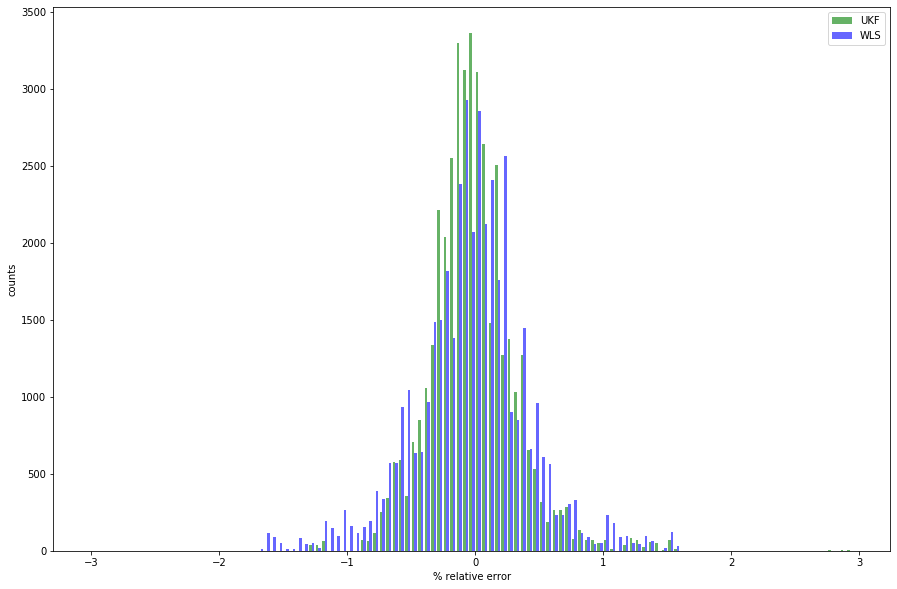

In [20]:
#retrieving sample grid from simbench
# sb_code = "1-MV-comm--0-sw"
sb_code = "1-MV-urban--0-sw"
# sb_code = "1-MV-urban--0-sw"
net = sb.get_simbench_net(sb_code)
# in simbench sgen is positive for generation but in pandapower sgen is negative for generation
# converting positive value to negative for use in pandapower
net.sgen.loc[:, ['p_mw', 'q_mvar']] *= -1

# standard deviations
std_v_bus = 0.003  # in pu
std_pq_pu = 0.0001

power_base = np.average(net.trafo.loc[:, 'sn_mva'].values)
std_pq = std_pq_pu * power_base

# drop initial measurements
iniMeas = np.arange(0, len(net.measurement))
net.measurement.drop(iniMeas, inplace=True)

create_measurements(std_pq, std_v_bus)

YMat, Yf, Yt, ppc, eppci = buildAdmittanceMat(net, init="flat", calculate_voltage_angles=False)

nBus, nBuspp, nBusAct, nMeas, slackbus = getBusInfo(YMat, net, ppc, eppci)

# get profile associated with the network
profiles = sb.get_absolute_values(net, profiles_instead_of_study_cases=True)

start = datetime.now()

# number of simulations needed
nSim = 3
# for storing the states
time_steps = range(50)

resultMask = createResultMask(net, nBus, nBusAct)

# select between EKF and UKF
alg = "UKF"
xs, real_xs, wls_xs, nUpdates = runSimulations(alg, nSim, time_steps, net, nBus, nBusAct, nMeas, std_pq, std_v_bus, profiles, resultMask)
# saveArrays(xs = xs, wls_xs = wls_xs, real_xs = real_xs)

# # Plotting the estimated and real values of a particular state variable
# plotStates(alg, 10, time_steps, xs, real_xs, wls_xs)
# plotStates(alg, 200, time_steps, xs, real_xs, wls_xs)
# # Plotting the relative error of estimated values
plotError(alg, real_xs, wls_xs, xs)

# # plotError(real_xs, wls_xs, xs)

In [21]:
# real_xs = np.loadtxt('real_xs.txt')
# wls_xs = np.loadtxt('wls_xs.txt')
# xs = np.loadtxt('xs.txt')

# xs = xs.reshape(nSim,-1,len(time_steps))
# real_xs = real_xs.reshape(nSim,-1,len(time_steps))
# wls_xs = wls_xs.reshape(nSim,-1,len(time_steps))

# plotError(real_xs, wls_xs, xs)
# plotStates(180, time_steps, xs, real_xs, wls_xs)

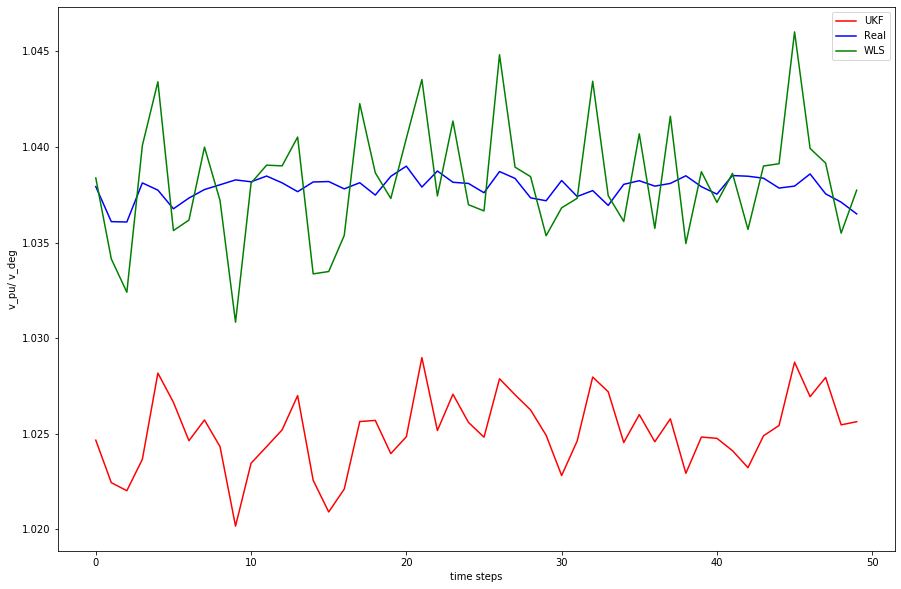

In [22]:
plotStates(alg, 150, time_steps, xs, real_xs, wls_xs)

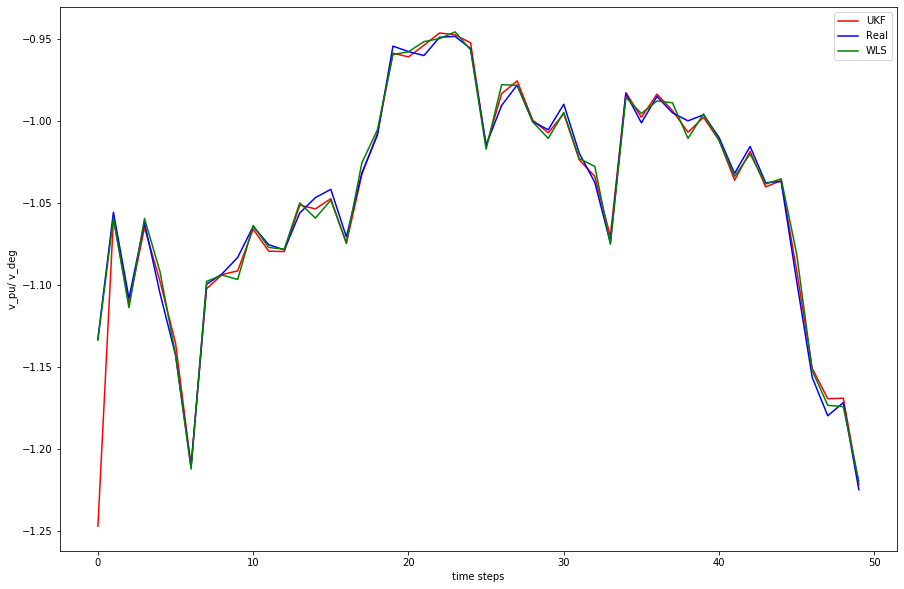

In [23]:
plotStates(alg, 17, time_steps, xs, real_xs, wls_xs)

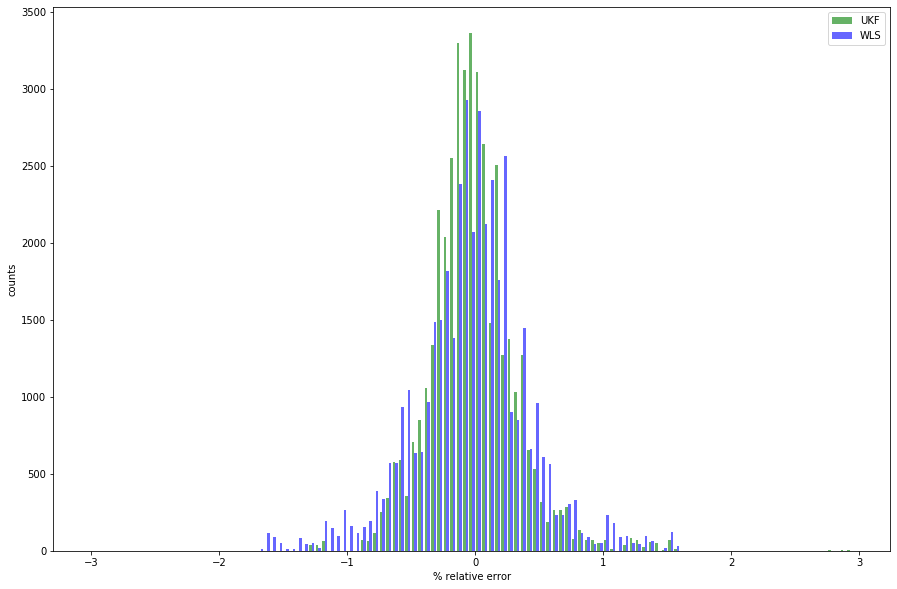

In [24]:
plotError(alg, real_xs, wls_xs, xs)